# Feature Engineering - Are these features worth existing?

In [24]:
# 3rd Party
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# linear_regression_001
from linear_regression_001.data.loader import load_clean_data
from linear_regression_001.features.build_features import split_features_target, build_features

# Pipeline
from sklearn.pipeline import Pipeline
# Categorical Encoding
from sklearn.preprocessing import OneHotEncoder
# Feature Scaling
from sklearn.preprocessing import StandardScaler
# Cross validation
from sklearn.model_selection import KFold, cross_val_score
# Metrics
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.metrics import r2_score as r2
# Modeling
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin


## Can I transform variables so assumptions are more plausible?
1. log-transform skewed variables
2. create interaction terms
3. add polynomial terms
4. remove redundant predictors
5. standardize features
6. engineer ratios instead of raw values
## Engineer towards linearity. Still not testing assumptions -- just improving model compatibility.

In [25]:
# Look at signal after split with Correlations, SHAP, and importances.

In [26]:
df = load_clean_data('cleaned_insurance.csv')
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1332,50,male,30.970,3,no,northwest,10600.54830
1333,18,female,31.920,0,no,northeast,2205.98080
1334,18,female,36.850,0,no,southeast,1629.83350
1335,21,female,25.800,0,no,southwest,2007.94500


In [27]:
X, y = split_features_target(df)
X

,age,sex,bmi,children,smoker,region
0,19,female,27.900,0,yes,southwest
1,18,male,33.770,1,no,southeast
2,28,male,33.000,3,no,southeast
3,33,male,22.705,0,no,northwest
4,32,male,28.880,0,no,northwest
...,...,...,...,...,...,...
1332,50,male,30.970,3,no,northwest
1333,18,female,31.920,0,no,northeast
1334,18,female,36.850,0,no,southeast
1335,21,female,25.800,0,no,southwest


In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
# Numeric and Categorical Split
# Train
# num_feat_train = X_train.select_dtypes(include='number')
# cat_feat_train = X_train.select_dtypes(exclude='number')
# Test
# num_feat_test = X_test.select_dtypes(include='number')
# cat_feat_test = X_test.select_dtypes(exclude='number')

In [30]:
# Set up an experiment - list out baseline and candidate_feats
# These are names in the FEATURE_REGISTRY that refer to individual feature definitions
baseline_feats = ["log_bmi"]
# Candidate features must include the baseline feats
candidate_feats = ["log_bmi"]

In [31]:
# FeatureBuilder wrapper
class FeatureBuilder(BaseEstimator, TransformerMixin):
    def __init__(self,feature_list):
        self.feature_list = feature_list

    def fit(self, X ,y=None):
        return self

    def transform(self,X):
        return build_features(X, self.feature_list)

In [32]:
# cv and scorer setup
cv = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

In [33]:
# CV comparison w/ pipelines

# Baseline
# pipelines are used to protect from data leakage by fitting only on training folds
baseline_pipeline = Pipeline([
    ("features", FeatureBuilder(baseline_feats)),
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

baseline_scores = cross_val_score(
    baseline_pipeline, X, y,
    cv = cv,
    scoring = rmse_scorer
)

print("Baseline RMSE:", baseline_scores.mean())
print("Baseline RMSE:", baseline_scores)

Baseline RMSE: -141129195.3381092
Baseline RMSE: [-1.74825378e+08 -1.36651087e+08 -1.35491114e+08 -1.17317702e+08
 -1.41360696e+08]


In [38]:
print(FeatureBuilder(baseline_feats))

FeatureBuilder(feature_list=['log_bmi'])


In [34]:
# Candidate
# pipelines are used to protect from data leakage by fitting only on training folds
newfeat_pipeline = Pipeline([
    ("features", FeatureBuilder(candidate_feats)),
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

newfeat_scores = cross_val_score(
    newfeat_pipeline, X, y,
    cv = cv,
    scoring = rmse_scorer
)

print("New Feature RMSE:", newfeat_scores.mean())
print("New Feature RMSE:", newfeat_scores)

New Feature RMSE: -141129195.3381092
New Feature RMSE: [-1.74825378e+08 -1.36651087e+08 -1.35491114e+08 -1.17317702e+08
 -1.41360696e+08]


In [36]:
improvement = baseline_scores - newfeat_scores
print("Fold improvements:", improvement)
print("Mean improvement:", improvement.mean())

# If consistent, promote to feature permanently

Fold improvements: [0. 0. 0. 0. 0.]
Mean improvement: 0.0


#### Math Calc
- polynomial terms
- combining features
- interaction terms

In [ ]:
# Polynomial terms


#### bmi

We suspect right skew, let's plot a histogram to see. Then we can log transform bmi (within X) and charges (y) -- a functional transformation.

Text(0.5, 1.0, 'Histogram of Bmi')

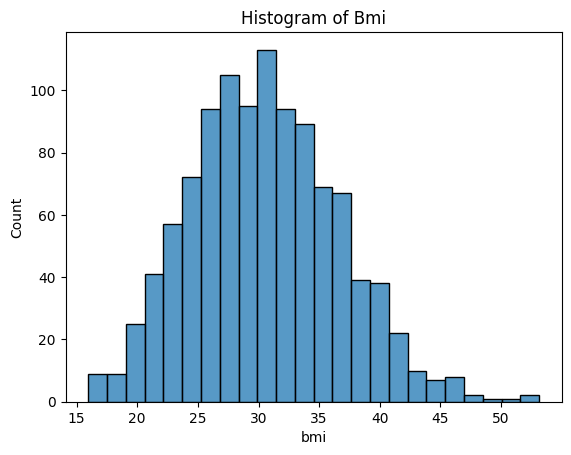

In [6]:
# Visualize
sns.histplot(X_train,x='bmi')
plt.title('Histogram of Bmi')

There is a right skew present that we can transform.

Text(0.5, 1.0, 'Log of Bmi')

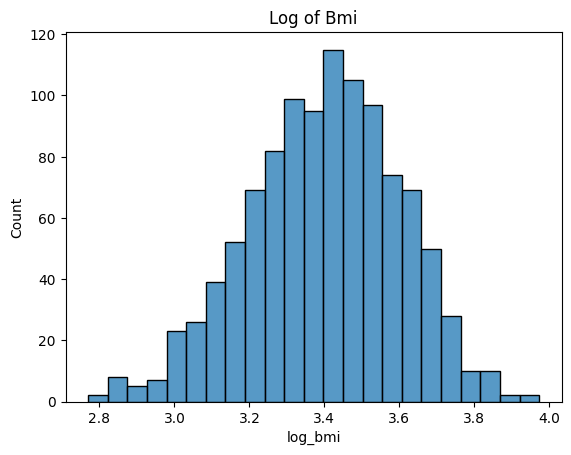

In [7]:
# Create a transformed column and visualize it
X_train['log_bmi'] = np.log(X_train['bmi'])
sns.histplot(X_train,x='log_bmi')
plt.title('Log of Bmi')

We now see that it is more symmetrical with less skew to the right.

In [8]:
# Drop it from X_train
# X_train = X_train.drop(columns='bmi')

# Within test: transform bmi to log_bmi and drop the original bmi column
X_test['log_bmi'] = np.log(X_test['bmi'])
# X_test = X_test.drop(columns=['bmi'])

#### charges

Text(0.5, 1.0, 'Histogram of Charges')

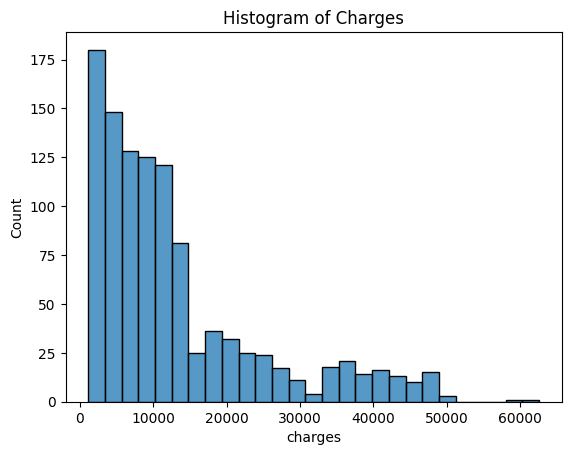

In [9]:
# Visualize
sns.histplot(y_train)
plt.title('Histogram of Charges')

There is a heavy right skew present we can transform.

In [10]:
y_train

1113     2396.09590
967      3279.86855
598     33471.97189
170     13405.39030
275      9715.84100
           ...     
1095    44641.19740
1130     3693.42800
1294     1964.78000
860      7151.09200
1126     5836.52040
Name: charges, Length: 1069, dtype: float64

In [14]:
y_train_log = np.log(y_train)
y_train_log = y_train_log.rename('log_charges')

In [16]:
y_train = pd.concat([y_train,y_train_log],axis=1)
y_train

,charges,log_charges
1113,2396.09590,7.781596
967,3279.86855,8.095559
598,33471.97189,10.418464
170,13405.39030,9.503412
275,9715.84100,9.181513
...,...,...
1095,44641.19740,10.706412
1130,3693.42800,8.214310
1294,1964.78000,7.583136
860,7151.09200,8.875020


Text(0.5, 1.0, 'log charges')

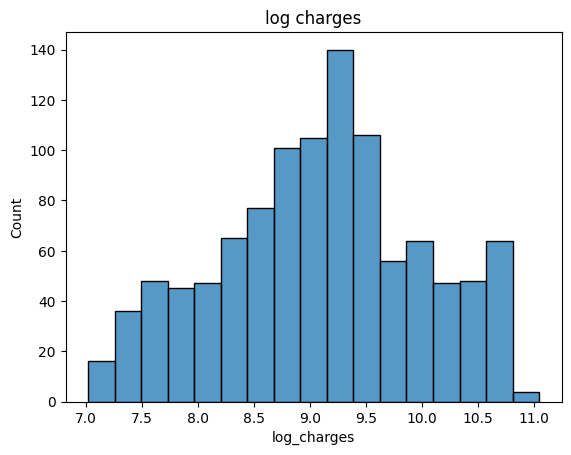

In [17]:
# Create a transformed column and visualize it
sns.histplot(y_train['log_charges'])
plt.title('log charges')

We see that the distribution is more symmetrical compared to its original heavy right skew. We can np.exp to get the original value later.

In [ ]:
# Transform y_test
y_test_log = np.log(y_test)
y_test_log = y_test_log.rename('log_charges')
y_test = pd.concat([y_test,y_test_log],axis=1)


In [20]:
X_train

,age,sex,bmi,children,smoker,region,log_bmi
1113,23,male,24.510,0,no,northeast,3.199081
967,21,male,25.745,2,no,northeast,3.248240
598,52,female,37.525,2,no,northwest,3.625007
170,63,male,41.470,0,no,southeast,3.724970
275,47,female,26.600,2,no,northeast,3.280911
...,...,...,...,...,...,...,...
1095,51,female,34.960,2,yes,northeast,3.554205
1130,27,male,45.900,2,no,southwest,3.826465
1294,20,male,22.000,1,no,southwest,3.091042
860,38,female,28.000,3,no,southwest,3.332205



#### Categorical Mappings
- binary columns
- dummy variables
- binning

In [21]:
cat_feat_train

,sex,smoker,region
1113,male,no,northeast
967,male,no,northeast
598,female,no,northwest
170,male,no,southeast
275,female,no,northeast
...,...,...,...
1095,female,yes,northeast
1130,male,no,southwest
1294,male,no,southwest
860,female,no,southwest


In [22]:
# What columns could we encode?
cat_feat_col = cat_feat_train.columns.to_list()
cat_feat_train.columns.to_list()

['sex', 'smoker', 'region']

In [23]:
# We want to one hot encode sex, smoker, and region which are nominal variables with low cardinality.
#ohe = OneHotEncoder(handle_unknown='ignore',drop='first',sparse_output=False).set_output(transform='pandas')
ohe = OneHotEncoder(handle_unknown='ignore',sparse_output=False).set_output(transform='pandas')
X_train_cat = ohe.fit_transform(X_train[cat_feat_col])
X_test_cat = ohe.transform(X_test[cat_feat_col])

In [24]:
# Newly encoded with first category of categorical variable dropped
X_train_cat

,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
1113,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
967,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
598,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
170,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
275,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
1095,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1130,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1294,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
860,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [25]:
# Concatenate and drop old categorical columns for newly encoded categorical columns
# X_train = pd.concat([X_train,X_train_cat],axis=1).drop(columns=['sex','smoker','region'])
# X_test = pd.concat([X_test,X_test_cat],axis=1).drop(columns=['sex','smoker','region'])
X_train = pd.concat([X_train,X_train_cat],axis=1)
X_test = pd.concat([X_test,X_test_cat],axis=1)

In [26]:
X_train

,age,sex,bmi,children,smoker,region,log_bmi,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
1113,23,male,24.510,0,no,northeast,3.199081,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
967,21,male,25.745,2,no,northeast,3.248240,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
598,52,female,37.525,2,no,northwest,3.625007,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
170,63,male,41.470,0,no,southeast,3.724970,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
275,47,female,26.600,2,no,northeast,3.280911,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,51,female,34.960,2,yes,northeast,3.554205,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1130,27,male,45.900,2,no,southwest,3.826465,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1294,20,male,22.000,1,no,southwest,3.091042,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
860,38,female,28.000,3,no,southwest,3.332205,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


#### Dt Calc
- days from today
- time between dates

#### Group Calc
- aggregations
- ranks w/in groups

#### Scaling
- standardization
- normalization